In [2]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt
from interactions import apply_rule, make_line, make_grid
from itertools import combinations_with_replacement

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def traverse_all_paths(model, input_space_x, outcome_space_y, S, continuous_y = False):
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    datasets = {}
    num_feats = len(S)#np.count_nonzero(S)
    datasets[0] = (input_space_x, outcome_space_y)
    intervals = {}
    intervals[0] =[(- float('inf'), float('inf'))] * num_feats
    encounters = {}
    encounters[0] = False
    leaves = []
    fringe = [0]
    while len(fringe) > 0:
        curr_node = fringe.pop()
        #print("curr_node", curr_node)
        bound = threshold[curr_node]
        feat = feature[curr_node]
        #print("bound", bound, "on feature", feat)
        child_left = children_left[curr_node]
        child_right = children_right[curr_node]
        #print("children (left, right)", child_left, child_right)
        if (child_left != child_right):
            #print("non-leaf")
            X, Y = datasets[curr_node]
            #print("current node data set X\n", X)
            #print("current node data set Y\n", Y)
            left_data = (X, Y)
            right_data = (X, Y)
            left_interval = intervals[curr_node]
            right_interval = intervals[curr_node]
            #print("current node interval", intervals[curr_node])
            if(S[feat] == 1):
                encounters[curr_node] = True
                left_data = apply_rule(X, Y, bound, feat, "less")
                #print("left data", left_data)
                right_data = apply_rule(X, Y, bound, feat, "geq")
                #print("right data", right_data)

                left_interval = intervals[curr_node][0:feat] + [(intervals[curr_node][feat][0], bound)] + intervals[curr_node][feat + 1:len(intervals[curr_node])]
                #print("left interval", left_interval)
                right_interval = intervals[curr_node][0:feat] + [(bound, intervals[curr_node][feat][1])] + intervals[curr_node][feat + 1:len(intervals[curr_node])]
                #print("right interval", right_interval)
            encounters[child_left] = encounters[curr_node]
            encounters[child_right] = encounters[curr_node]
            datasets[child_left] = left_data
            datasets[child_right] = right_data
            intervals[child_left] = left_interval
            intervals[child_right] = right_interval
            fringe.append(child_left)
            fringe.append(child_right)
        else:
            #print("leaf")
            leaves.append(curr_node)
    values = []
    #print("leaves", leaves)
    if(continuous_y):
        for leaf in leaves:
            X, Y = datasets[leaf]
            inter = intervals[leaf]
            average = np.average(Y)
            if(encounters[leaf]):
                values.append(inter + [average] + [len(Y)])
        return values
    for leaf in leaves:
        X, Y = datasets[leaf]
        inter = intervals[leaf]
        proportion = np.count_nonzero(Y == 1)/Y.shape[0]
        if(encounters[leaf]):
            values.append(inter + [proportion] + [len(Y)])
    return values

In [5]:
#output: X is a n*2 matrix with values ~ Uniform(x_range)
#y is of the form a * x1^2 + b * x2^2 + c * x1x2 + d * x1 + e * x2 + f, all coefficients specified in array argument
def make_polynomial_data(n, x_range, coeffs):
    X = np.random.uniform(x_range[0], x_range[1], (n, 2))
    x1 = X[:, 0]
    x2 = X[:, 1]
    y = coeffs[0] * x1 * x1 + coeffs[1] * x2 * x2 + coeffs[2] * x1 * x2 + coeffs[3] * x1 + coeffs[4] * x2 + coeffs[5]
    return X, y

In [4]:
def train_tree(X, y, depth_lim = None):
    model = DecisionTreeRegressor(max_depth=depth_lim)
    model.fit(X, y)
    return model

In [11]:
def random_poly():
    integer_coeffs = np.arange(-9, 10)
    coeffs = np.random.choice(integer_coeffs, 6)
    print(coeffs)
    X, y = make_polynomial_data(10000, (0, 10), coeffs)
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 0], continuous_y=True)
    short_line = make_line(short_vals, (0, 10), .1, 0, 2)
    tall_line = make_line(tall_vals, (0, 10), .1, 0, 2)
    x_axis = np.arange(0, 10, .1)
    e_x_squared = (100/12.0) + 25
    expectation = coeffs[0] * x_axis ** 2 + coeffs[1] * e_x_squared + coeffs[2] * 5 * x_axis + coeffs[3] * x_axis + coeffs[4] * 5 + coeffs[5]
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, short_line, 'k', c='b', label='short tree')
    plt.plot(x_axis, tall_line, 'k', c='g', label='tall tree')
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.show()

[-3  9  0 -2  9 -8]


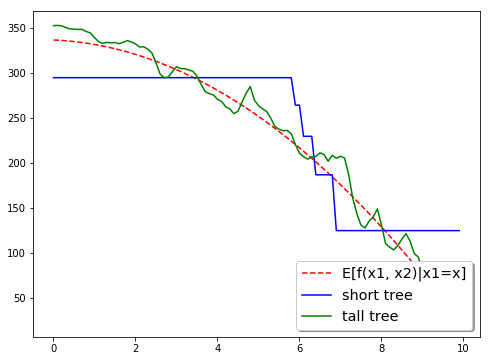

In [59]:
random_poly()

[-5  8  9 -6 -9 -9]


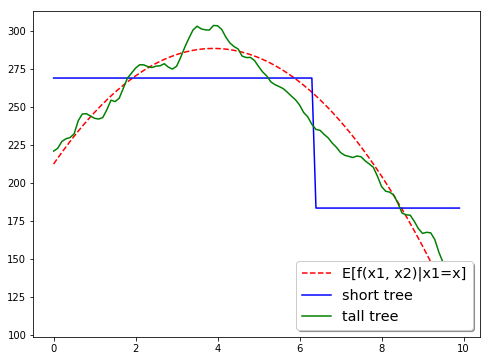

In [60]:
random_poly()

[ 1  5  2 -5  6 -3]


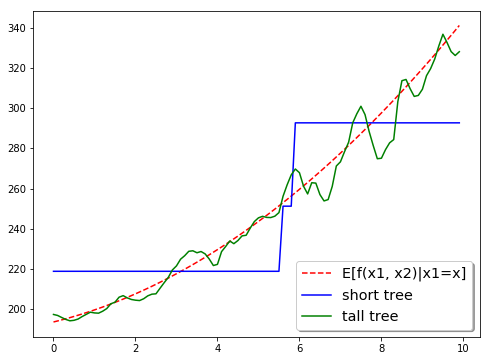

In [61]:
random_poly()

In [16]:
def make_three_var_data(n, x_range, coeffs):
    X = np.random.uniform(x_range[0], x_range[1], (n, 3))
    const = np.ones((n, 1))
    X_const = np.hstack((X, const))
    l = list(combinations_with_replacement(np.transpose(X_const), 2))
    y = np.zeros(n)
    for i in range(len(coeffs)):
        y += coeffs[i] * l[i][0] * l[i][1]
    return X, y

In [17]:
def make_heatmap(vals, label):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    im = ax.imshow(vals)
    cbar_kw = {}
    cbarlabel = label
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_xticks(np.arange(100, step=10))
    ax.set_yticks(np.arange(100, step=10))
    ax.set_xticklabels(np.round(np.arange(0, 10, step = 1), 2))
    ax.set_yticklabels(np.round(np.arange(0, 10, step = 1), 2))
    plt.show()

In [18]:
def conditional_exp(x1_range, x2_range, coeffs):
    e_x = 5
    e_x_squared = (100/12.0) + 25
    vals = np.zeros((len(x1_range), len(x2_range)))
    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            x1 = x1_range[i]
            x2 = x2_range[j]
            prods = np.array([x1 * x1, x1 * x2, x1 * e_x, x1, x2 * x2, x2 * e_x, x2, e_x_squared, e_x, 1])
            vals[j, i] = np.sum(prods * coeffs)
    return vals

In [19]:
def specified_poly_3rd_degree(coeffs):
    X, y = make_three_var_data(1000, (0, 10), coeffs)
    print("avg", np.mean(X[:, 2]), "sqrd", np.mean(X[:, 2] ** 2))
    print("y max", max(y), "y min", min(y), "y mean", np.mean(y))
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 1, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 1, 0], continuous_y=True)
    short_grid = make_grid(short_vals, (0, 10), (0, 10), .1, 3)
    tall_grid = make_grid(tall_vals, (0, 10), (0, 10), .1, 3)
    x1_range = np.arange(0, 10, .1)
    x2_range = np.arange(0, 10, .1)
    expectation = conditional_exp(x1_range, x2_range, coeffs)
    make_heatmap(short_grid, "short tree scores")
    make_heatmap(tall_grid, "tall tree scores")
    make_heatmap(expectation, "conditional expectation")

coeffs [-5 -6 -9 -7 -3  6 -2 -3  8 -5]
avg 4.966924880118006 sqrd 33.08351755923435
y max 24.932129877277774 y min -1833.1293646365518 y mean -579.2266999427892


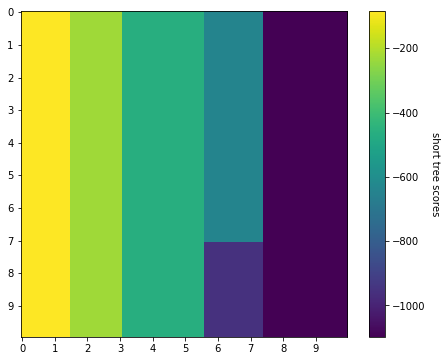

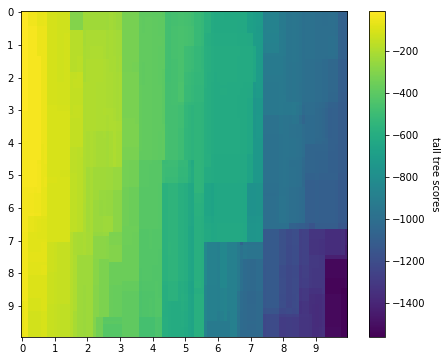

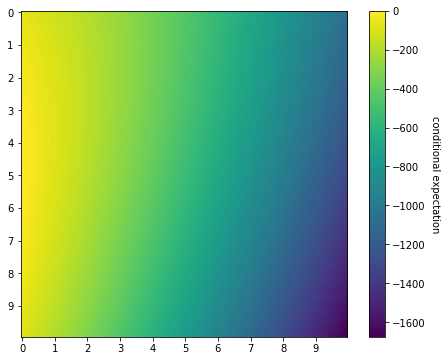

In [62]:
coeff_range = np.arange(-9, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

coeffs [-3 -8  1  9 -1 -3 -5  2  8  1]
avg 5.050228238923555 sqrd 33.74273176202821
y max 276.69558425031994 y min -1109.2585475998578 y mean -248.50582801796784


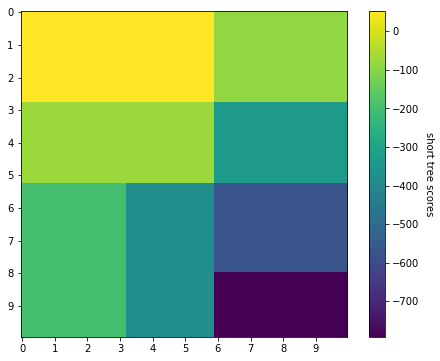

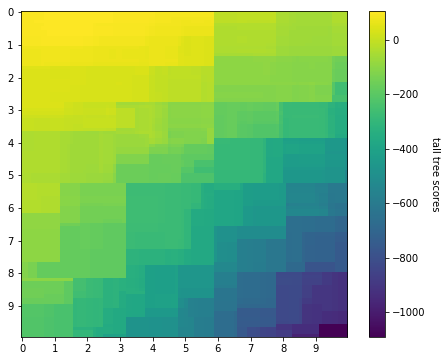

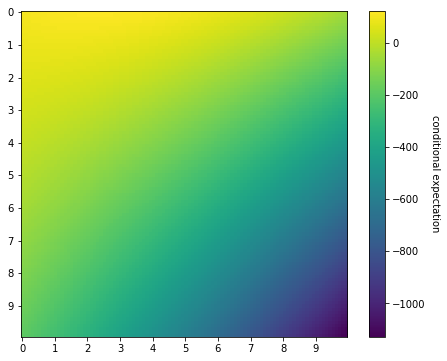

In [21]:
coeff_range = np.arange(-10, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

coeffs [-1  5 -3  6 -9 -9 -3  9  2  4]
avg 4.9113498027611175 sqrd 32.26182172408324
y max 760.0680560030198 y min -1025.731295902715 y mean -167.77122388375165


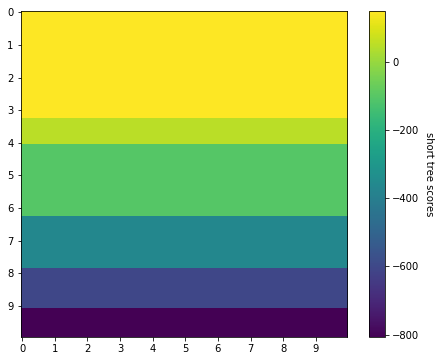

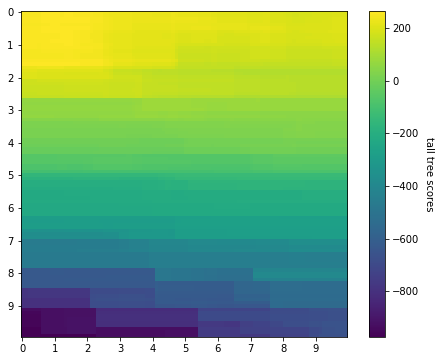

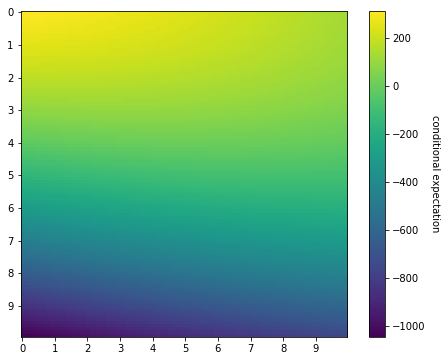

In [63]:
coeff_range = np.arange(-10, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

coeffs [-5 -3 -2  3 -3 -8  0 -5  9  6]
avg 4.843967077543334 sqrd 31.823114943910035
y max 5.0755377462096956 y min -2271.0471585501177 y mean -670.0136480130955


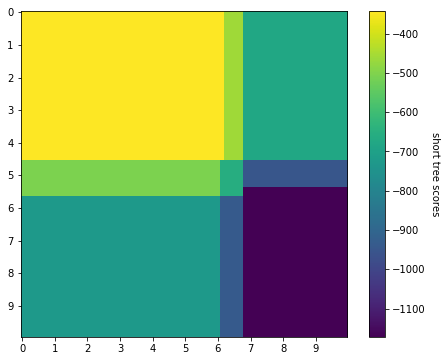

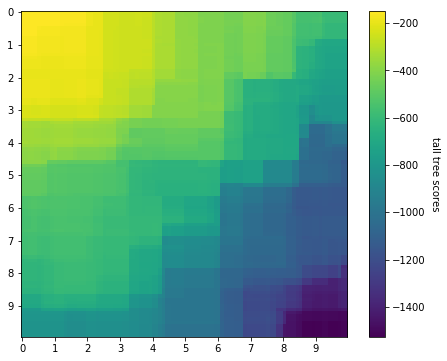

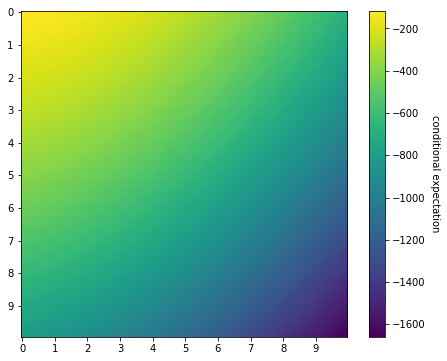

In [64]:
coeff_range = np.arange(-10, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

In [48]:
def many_ands(n, num_ands, x_axis):
    X = np.random.uniform(0, 10, (n, 2))
    y = np.zeros(n)
    y_test = np.zeros(n)
    exp = np.zeros(x_axis.shape)
    rules = []
    for i in range(num_ands):
        x1_bound, x2_bound = np.random.uniform(0, 10, (2))
        y += np.logical_and(X[:, 0] < x1_bound, X[:, 1] > x2_bound)
        exp += (x_axis < x1_bound) * (10 - x2_bound)/10.0
        rules.append((x1_bound, x2_bound))
    return X, y, exp, rules

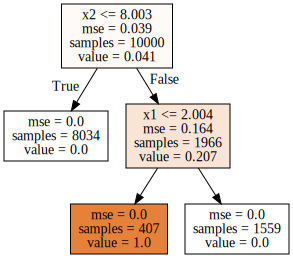

Vals [[(2.004026174545288, inf), (-inf, inf), 0.0, 7985], [(-inf, 2.004026174545288), (-inf, inf), 0.20198511166253103, 2015]]


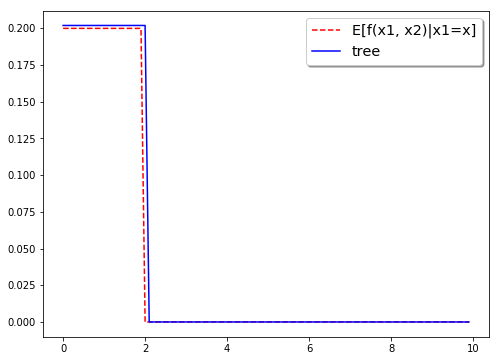

In [49]:
X = np.random.uniform(0, 10, (10000, 2))
labels = ['x1', 'x2']
x1_bound, x2_bound = 2, 8
y = np.logical_and(X[:, 0] < x1_bound, X[:, 1] > x2_bound)
model = train_tree(X, y)
graph = Source(tree.export_graphviz(model, out_file=None
   , feature_names=labels, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))
vals = traverse_all_paths(model, X, y, [1, 0], continuous_y=True)
print("Vals", vals)
line = make_line(vals, (0, 10), .1, 0, 2)
x_axis = np.arange(0, 10, .1)
expectation = (x_axis < x1_bound) * (10 - x2_bound)/10.0
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
plt.plot(x_axis, line, 'k', c='b', label='tree')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

In [50]:
def random_ands(num_ands):
    x_axis = np.arange(0, 10, .1)
    X, y, expectation, _ = many_ands(10000, num_ands, x_axis)
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 0], continuous_y=True)
    short_line = make_line(short_vals, (0, 10), .1, 0, 2)
    tall_line = make_line(tall_vals, (0, 10), .1, 0, 2)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, short_line, 'k', c='b', label='short tree')
    plt.plot(x_axis, tall_line, 'k', c='g', label='tall tree')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

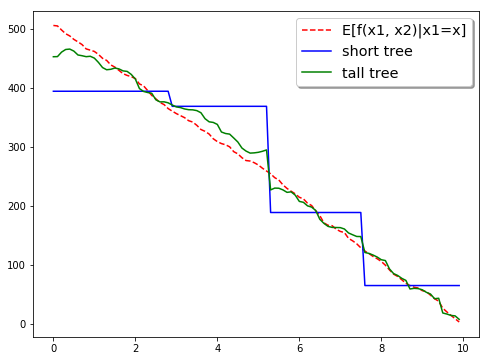

In [51]:
random_ands(1000)

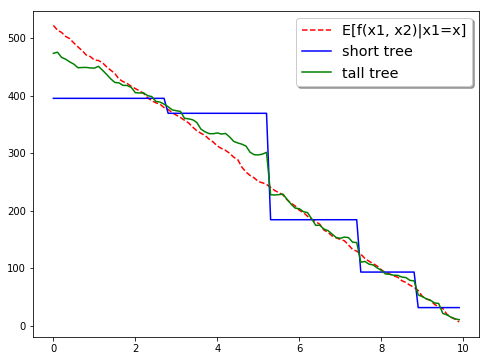

In [52]:
random_ands(1000)

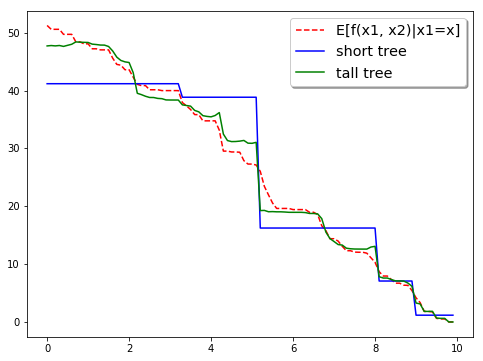

In [54]:
random_ands(100)

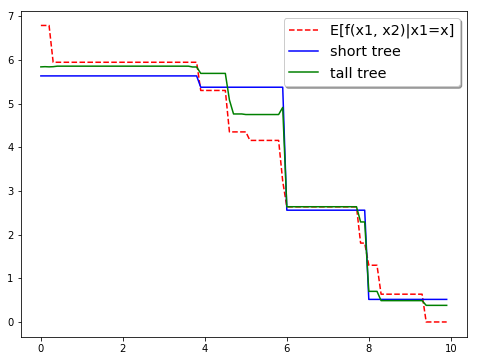

In [55]:
random_ands(10)

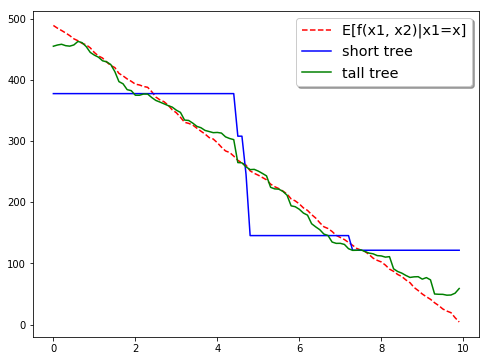

In [56]:
random_ands(1000)

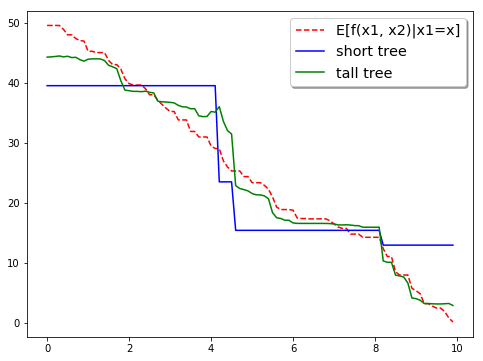

In [57]:
random_ands(100)

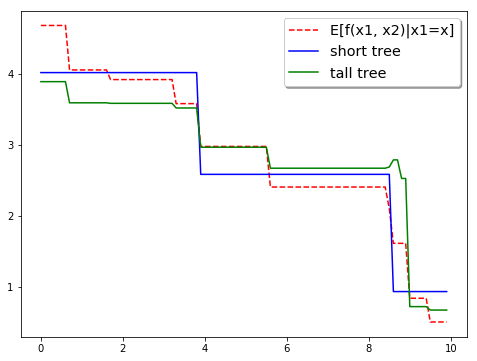

In [58]:
random_ands(10)

In [73]:
def specified_poly_forest(numtrees, coeffs):
    X, y = make_polynomial_data(5000, (0, 10), coeffs)
    forest = RandomForestRegressor(n_estimators=numtrees)
    forest.fit(X, y)
    models = forest.estimators_
    line = np.zeros(100)
    for model in models:
        vals = traverse_all_paths(model, X, y, [1, 0], continuous_y=True)
        line += make_line(vals, (0, 10), .1, 0, 2)
    line = line/(numtrees * 1.0)
    x_axis = np.arange(0, 10, .1)
    e_x_squared = (100/12.0) + 25
    expectation = coeffs[0] * x_axis ** 2 + coeffs[1] * e_x_squared + coeffs[2] * 5 * x_axis + coeffs[3] * x_axis + coeffs[4] * 5 + coeffs[5]
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, line, 'k', c='g', label='forest tree')
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.show()

[ 5  2 -8  9 -2  9]


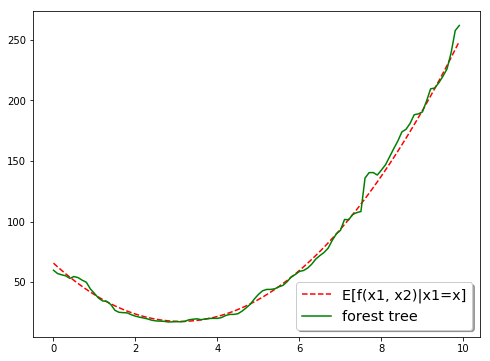

In [74]:
integer_coeffs = np.arange(-9, 10)
coeffs = np.random.choice(integer_coeffs, 6)
print(coeffs)
specified_poly_forest(100, coeffs)

[ 9 -1  6 -7 -4 -9]


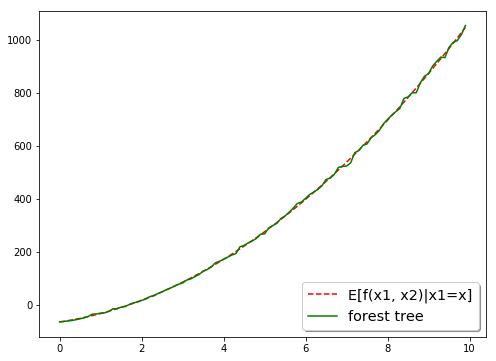

In [75]:
integer_coeffs = np.arange(-9, 10)
coeffs = np.random.choice(integer_coeffs, 6)
print(coeffs)
specified_poly_forest(100, coeffs)

[-8 -4 -8  3 -9 -3]


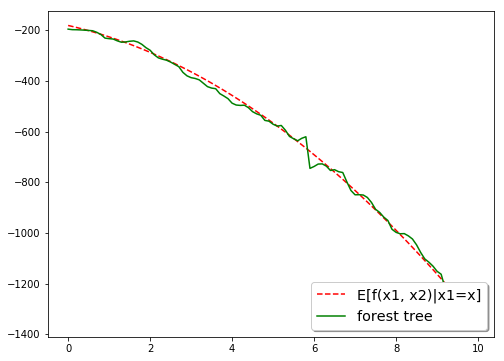

In [76]:
integer_coeffs = np.arange(-9, 10)
coeffs = np.random.choice(integer_coeffs, 6)
print(coeffs)
specified_poly_forest(100, coeffs)

[ 9  5 -5  9  1  6]


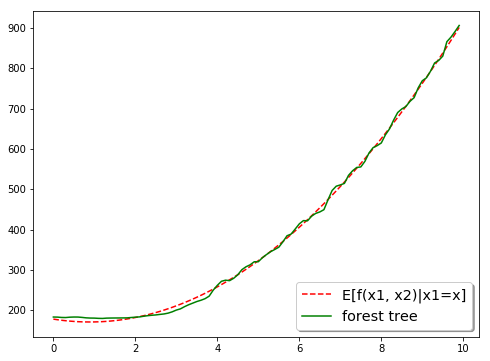

In [77]:
integer_coeffs = np.arange(-9, 10)
coeffs = np.random.choice(integer_coeffs, 6)
print(coeffs)
specified_poly_forest(100, coeffs)

In [83]:
def random_ands_forest(numtrees, num_ands):
    x_axis = np.arange(0, 10, .1)
    X, y, expectation, rules = many_ands(10000, num_ands, x_axis)
    
    forest = RandomForestRegressor(n_estimators=numtrees)
    forest.fit(X, y)
    models = forest.estimators_
    line = np.zeros(100)
    for model in models:
        vals = traverse_all_paths(model, X, y, [1, 0], continuous_y=True)
        line += make_line(vals, (0, 10), .1, 0, 2)
    line = line/(numtrees * 1.0)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, line, 'k', c='b', label='tree')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

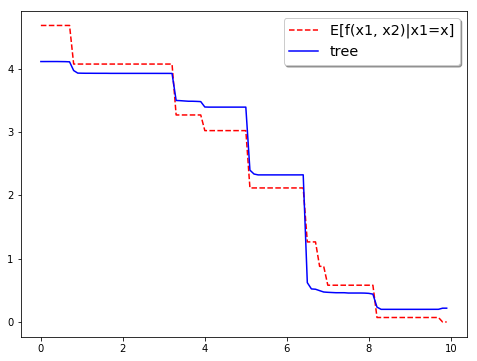

In [87]:
random_ands_forest(100, 10)

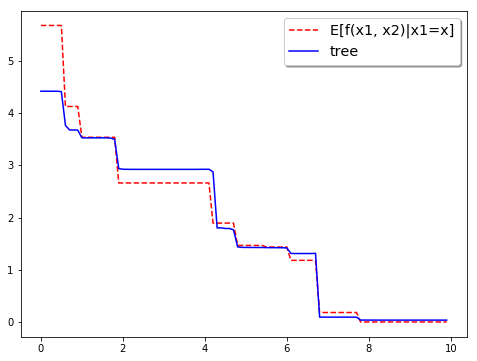

In [88]:
random_ands_forest(100, 10)

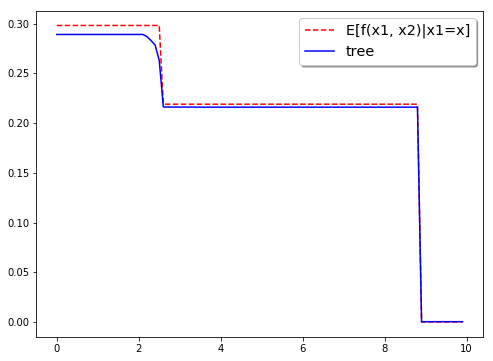

In [89]:
random_ands_forest(100, 2)

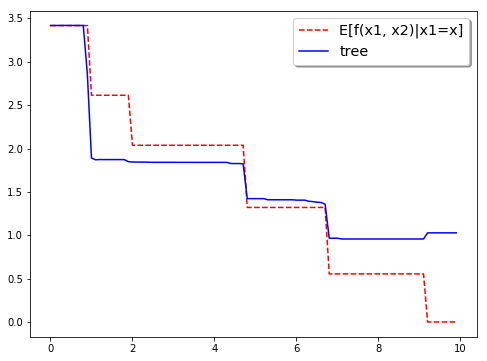

In [93]:
random_ands_forest(100, 5)

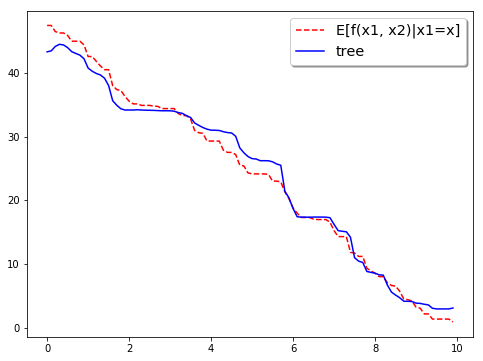

In [95]:
random_ands_forest(100, 100)

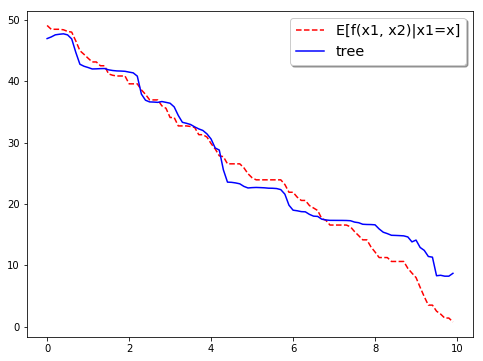

In [96]:
random_ands_forest(100, 100)

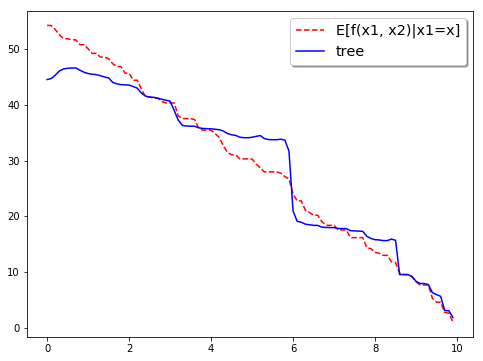

In [97]:
random_ands_forest(100, 100)

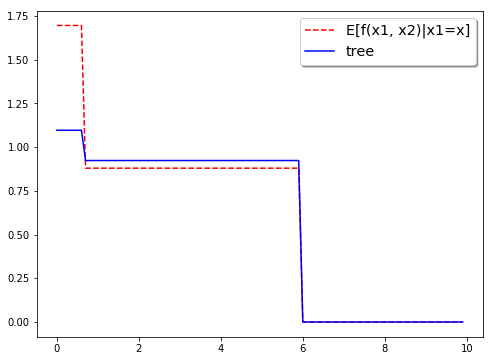

In [98]:
random_ands_forest(100, 2)

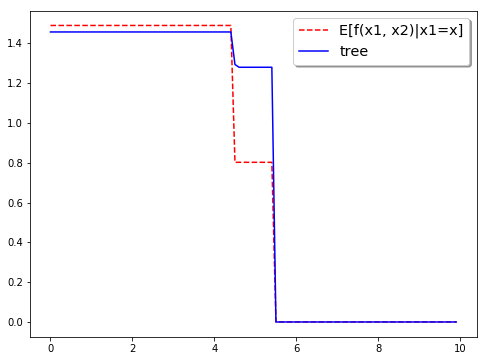

In [100]:
random_ands_forest(100, 2)

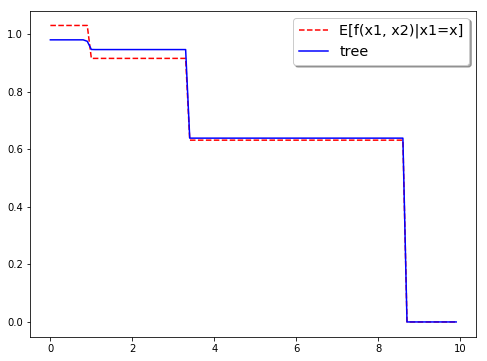

In [101]:
random_ands_forest(100, 3)

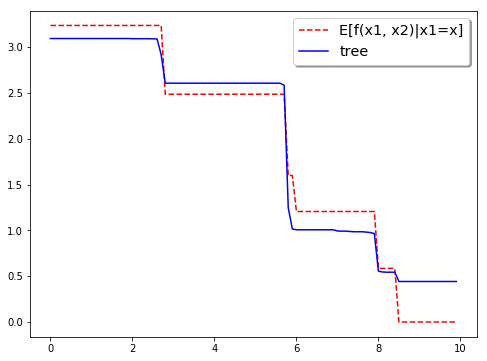

In [102]:
random_ands_forest(100, 5)

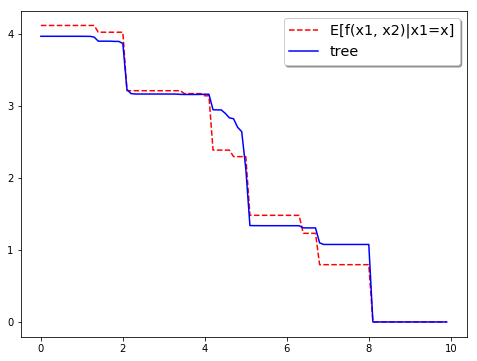

In [103]:
random_ands_forest(100, 10)

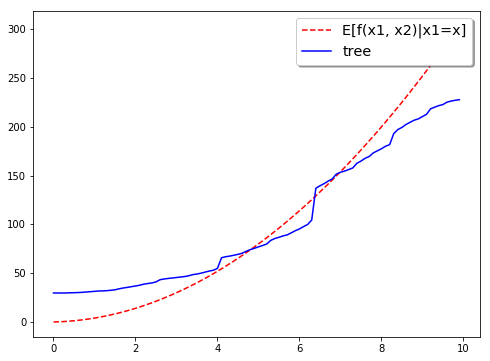

In [13]:
X = np.random.uniform(0, 10, (10000, 1))
X = np.hstack((X, 3 * X + 1))
numtrees = 100
y = X[:, 0] * X[:, 1]
forest = RandomForestRegressor(n_estimators=numtrees)
forest.fit(X, y)
models = forest.estimators_
line = np.zeros(100)
for model in models:
    vals = traverse_all_paths(model, X, y, [1, 0], continuous_y=True)
    line += make_line(vals, (0, 10), .1, 0, 2)
line = line/(numtrees * 1.0)
x_axis = np.arange(0, 10, .1)
expectation = x_axis * (3 * x_axis + 1)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
plt.plot(x_axis, line, 'k', c='b', label='tree')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()